In [1]:
# https://www.kaggle.com/code/emiz6413/training-gemma-2-9b-4-bit-qlora-fine-tuning

In [2]:
# gemma-2 is available from transformers>=4.42.3
!pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft

In [3]:
!pip install datasets

In [4]:
!pip install scikit-learn

In [5]:
import time
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor

import torch
import sklearn
import numpy as np
import pandas as pd
from transformers import Qwen2ForSequenceClassification, Qwen2TokenizerFast, BitsAndBytesConfig
from transformers.data.data_collator import pad_without_fast_tokenizer_warning
from peft import PeftModel

In [6]:
@dataclass
class Config:
    qwen2_dir = 'unsloth/Qwen2-72B-bnb-4bit'
    lora_dir = 'qwen2001/checkpoint-2000'
    max_length = 256
    batch_size = 4#global_batch_size
    device = torch.device("cuda")    

cfg = Config()

In [7]:
# テストデータの読み込み
test = pd.read_csv("../test.csv")

In [8]:
from typing import Any, Dict, List

def process_text(text: Any) -> str:
    if text is None:
        return ""
    if isinstance(text, str):
        try:
            return " ".join(eval(text, {"null": ""}))
        except:
            return str(text)
    else:
        return str(text)

def tokenize(
    tokenizer, Clothing_ID, Age, Title, Review_Text, Positive_Feedback_Count, max_length=cfg.max_length):

    Clothing_ID = ["<Clothing ID>: " + process_text(t) for t in Clothing_ID]
    Age = ["\n\n<Age>: " + process_text(t) for t in Age]
    Title = ["\n\n<Title>: " + process_text(t) for t in Title]
    Review_Text = ["\n\n<Review Text>: " + process_text(t) for t in Review_Text]
    Positive_Feedback_Count = ["\n\n<Positive Feedback Count>: " + process_text(t) for t in Positive_Feedback_Count]

    texts = [c + a + t + r + p for c, a, t, r, p in zip(Clothing_ID, Age, Title, Review_Text, Positive_Feedback_Count)]
    tokenized = tokenizer(texts, max_length=max_length, truncation=True, padding=False)

    input_ids = tokenized.input_ids
    attention_mask = tokenized.attention_mask

    return input_ids, attention_mask

# データの処理
tokenizer = Qwen2TokenizerFast.from_pretrained(cfg.qwen2_dir)
tokenizer.add_eos_token = True
tokenizer.padding_side = "right"

data = pd.DataFrame()
data["input_ids"], data["attention_mask"] = tokenize(tokenizer, test["Clothing ID"], test["Age"], test["Title"], test["Review Text"], test["Positive Feedback Count"])
#data["length"] = data["input_ids"].apply(len)

In [9]:
data

,input_ids,attention_mask
0,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
11150,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
11151,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
11152,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
11153,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [10]:
data["input_ids"].value_counts()

input_ids
[20373, 385, 1596, 3034, 26818, 220, 17, 17, 21, 271, 27, 16749, 26818, 220, 18, 17, 271, 3125, 1002, 26818, 20021, 271, 27, 19432, 2918, 26818, 20021, 271, 27, 35490, 36857, 4504, 26818, 220, 15]                                                                                                                                                                                                                                                                                                                                                                                          4
[20373, 385, 1596, 3034, 26818, 220, 23, 18, 271, 27, 16749, 26818, 220, 18, 20, 271, 3125, 1002, 26818, 20021, 271, 27, 19432, 2918, 26818, 20021, 271, 27, 35490, 36857, 4504, 26818, 220, 15]                                                                                                                                                                                                                              

In [11]:
test

,Clothing ID,Age,Title,Review Text,Positive Feedback Count
0,0,32,So happy i bought this skirt!,"I love this skirt. it does run a little small,...",0
1,0,34,Runs small,"Beautiful patterns and colors, but it sits ver...",0
2,0,37,Love the comfort of thi skirt,It is easily paired with a nice tip for work a...,0
3,0,39,Way too small,"This is a beautiful skirt, but runs very small...",10
4,0,39,NaN,I usually wear a size 8/10 and i needed a larg...,0
...,...,...,...,...,...
11150,232,53,More beautiful in reality,I purchased this dress on a whim. it is easy t...,0
11151,232,58,Perfect dress!,This dress is very flattering on and can easil...,0
11152,232,60,Perfect dress,This is the most perfect dress i've ever bough...,0
11153,232,62,Really great!,This is a beautiful dress! not too interested ...,5


In [12]:
print(data["input_ids"][0])

[20373, 385, 1596, 3034, 26818, 220, 15, 271, 27, 16749, 26818, 220, 18, 17, 271, 3125, 1002, 26818, 2055, 6247, 600, 10788, 419, 37280, 2219, 27, 19432, 2918, 26818, 358, 2948, 419, 37280, 13, 432, 1558, 1598, 264, 2632, 2613, 11, 600, 11457, 458, 4960, 2613, 323, 432, 374, 10296, 518, 279, 28042, 11, 714, 2058, 4278, 13, 600, 614, 3949, 803, 71639, 389, 419, 37280, 1091, 7196, 4113, 600, 614, 12938, 13, 600, 3003, 1012, 10497, 518, 279, 29587, 3553, 553, 1251, 11629, 752, 1246, 1753, 807, 1075, 432, 13, 600, 1083, 975, 448, 6837, 11, 323, 807, 678, 2948, 432, 438, 1632, 382, 27, 35490, 36857, 4504, 26818, 220, 15]


In [13]:
print(data["input_ids"][1])

[20373, 385, 1596, 3034, 26818, 220, 15, 271, 27, 16749, 26818, 220, 18, 19, 271, 3125, 1002, 26818, 49990, 2613, 271, 27, 19432, 2918, 26818, 19490, 12624, 323, 7987, 11, 714, 432, 23011, 1602, 1550, 323, 8473, 2613, 13, 600, 2776, 14279, 264, 1379, 220, 19, 323, 2684, 279, 2613, 13, 1147, 6450, 678, 279, 1616, 11, 714, 389, 279, 85601, 3108, 13, 279, 37280, 23011, 773, 1550, 429, 279, 13055, 5001, 1495, 572, 264, 2699, 28759, 13, 1741, 264, 20973, 1576, 432, 2167, 374, 6233, 323, 5868, 2244, 389, 279, 1614, 4658, 1576, 1340, 594, 12233, 264, 19125, 311, 10265, 1246, 1550, 432, 31227, 323, 1320, 5403, 700, 382, 27, 35490, 36857, 4504, 26818, 220, 15]


In [14]:
print(tokenizer.decode(data["input_ids"][0]))

<Clothing ID>: 0

<Age>: 32

<Title>: So happy i bought this skirt!

<Review Text>: I love this skirt. it does run a little small, i ordered an extra small and it is tight at the waist, but still works. i have received more compliments on this skirt than maybe anything i have owned. i've been stopped at the grocery store by people telling me how much they like it. i also work with kids, and they all love it as well.

<Positive Feedback Count>: 0


In [15]:
print(tokenizer.decode(data["input_ids"][1]))

<Clothing ID>: 0

<Age>: 34

<Title>: Runs small

<Review Text>: Beautiful patterns and colors, but it sits very high and runs small. i'm normally a size 4 and got the small. zipped all the way, but on the snug side. the skirt sits so high that the fabric coming down was a bit awkward. such a shame because it really is beautiful and looks great on the model probably because she's wearing a belt to hide how high it rides and flares out.

<Positive Feedback Count>: 0


In [16]:
print(tokenizer.decode(data["input_ids"][11154]))

<Clothing ID>: 232

<Age>: 63

<Title>: Love this dress!

<Review Text>: This dress is absolutely darling! it is light as a feather and floats on the body. the fabric looks almost handpainted and fits like a dream. i disagree with the previous poster and i think it looks very rich. super comfortable and i know i'll get lots of wear out of it. you can dress it up or dress it down. love it!

<Positive Feedback Count>: 2


In [17]:
print(tokenizer.decode(data["input_ids"][11154]))

<Clothing ID>: 232

<Age>: 63

<Title>: Love this dress!

<Review Text>: This dress is absolutely darling! it is light as a feather and floats on the body. the fabric looks almost handpainted and fits like a dream. i disagree with the previous poster and i think it looks very rich. super comfortable and i know i'll get lots of wear out of it. you can dress it up or dress it down. love it!

<Positive Feedback Count>: 2


In [18]:
# Load base model on GPU 0
device_0 = torch.device('cuda:0')
model_0 = Qwen2ForSequenceClassification.from_pretrained(
    cfg.qwen2_dir,
    device_map=device_0,
    use_cache=False,
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at unsloth/Qwen2-72B-bnb-4bit and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model_0 = PeftModel.from_pretrained(model_0, cfg.lora_dir)

In [20]:
from tqdm import tqdm

@torch.no_grad()
@torch.cuda.amp.autocast()
def inference(df, model, device, batch_size=cfg.batch_size, max_length=cfg.max_length):
    target = []

    # tqdmを使用してプログレスバーを表示
    progress_bar = tqdm(range(0, len(df), batch_size), desc="Inference")
    
    for start_idx in range(0, len(df), batch_size):
        end_idx = min(start_idx + batch_size, len(df))
        tmp = df.iloc[start_idx:end_idx]
        input_ids = tmp["input_ids"].to_list()
        attention_mask = tmp["attention_mask"].to_list()
        inputs = pad_without_fast_tokenizer_warning(
            tokenizer,
            {"input_ids": input_ids, "attention_mask": attention_mask},
            padding="longest",
            pad_to_multiple_of=None,
            return_tensors="pt",
        )
        outputs = model(**inputs.to(device))
        proba = outputs.logits.softmax(-1).cpu()
        
        target.extend(proba[:, 1].tolist())

        # オプション: プログレスバーの説明を更新して現在の進捗状況を表示
        progress_bar.set_postfix({"Processed": f"{end_idx}/{len(df)}"})
        
    
    df["target"] = target
    
    return df

In [21]:
"""
st = time.time()
results = inference(df=data, model=model_0, device=device_0)

print(f"elapsed time: {time.time() - st}")
"""

original_index = data.index.copy()
results = inference(df=data.reset_index(drop=True), model=model_0, device=device_0)
results = results.set_index(original_index)

Inference:   0%|          | 0/2789 [1:00:25<?, ?it/s, Processed=11155/11155]


In [22]:
results

,input_ids,attention_mask,target
0,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999922
1,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.354433
2,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999626
3,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.715821
4,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999491
...,...,...,...
11150,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999916
11151,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999926
11152,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999934
11153,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999659


In [23]:
print(tokenizer.decode(results["input_ids"][7863]))

<Clothing ID>: 165

<Age>: 57

<Title>: Cool summer skirt.

<Review Text>: 1. i'm 5'5" tall, 145 lbs, and 38-32-40. i wear a size 30 in hyphen chinos and they are loose. i could get in a size 10, but i felt the stretchiness made it look like it was pulling slightly. i decided to get the size 12 even though it was a hair loose.

2. the skirt hem is right above my knees. it's not as short as it appears on the model.

3. the back pockets are sewn shut, so they won't sag.

4. my only complaint is that the hook and eye at the waist pulls away funny, but i'm going to t

<Positive Feedback Count>: 10


In [24]:
print(tokenizer.decode(data["input_ids"][7863]))

<Clothing ID>: 165

<Age>: 57

<Title>: Cool summer skirt.

<Review Text>: 1. i'm 5'5" tall, 145 lbs, and 38-32-40. i wear a size 30 in hyphen chinos and they are loose. i could get in a size 10, but i felt the stretchiness made it look like it was pulling slightly. i decided to get the size 12 even though it was a hair loose.

2. the skirt hem is right above my knees. it's not as short as it appears on the model.

3. the back pockets are sewn shut, so they won't sag.

4. my only complaint is that the hook and eye at the waist pulls away funny, but i'm going to t

<Positive Feedback Count>: 10


In [25]:
#results.reset_index(drop=True)

In [26]:
test.iloc[11150]["Review Text"]

'I purchased this dress on a whim. it is easy to wear and very comfortable.  the empire waist is flattering. however, the dress runs large and the lower half is a-line. the neckline is very flattering and you feel put together when wearing this dress.\r\ni am happy to have it in my wardrobe. a go-to piece for years to come.'

In [27]:
sample_submission = pd.read_csv("../sample_submission.csv")
sample_submission

,target
0,0.488567
1,0.315813
2,0.764448
3,0.980691
4,0.406762
...,...
11150,0.922096
11151,0.692480
11152,0.236563
11153,0.267781


In [28]:
results.reset_index(drop=True)

,input_ids,attention_mask,target
0,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999922
1,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.354433
2,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999626
3,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.715821
4,"[20373, 385, 1596, 3034, 26818, 220, 15, 271, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999491
...,...,...,...
11150,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999916
11151,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999926
11152,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999934
11153,"[20373, 385, 1596, 3034, 26818, 220, 17, 18, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.999659


In [29]:
y_pred = results.reset_index(drop=True)["target"]

In [30]:
sample_submission['target'] = y_pred
sample_submission

,target
0,0.999922
1,0.354433
2,0.999626
3,0.715821
4,0.999491
...,...
11150,0.999916
11151,0.999926
11152,0.999934
11153,0.999659


In [32]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 197.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 227.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 250.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 72.1 MB/s eta 0:00:00


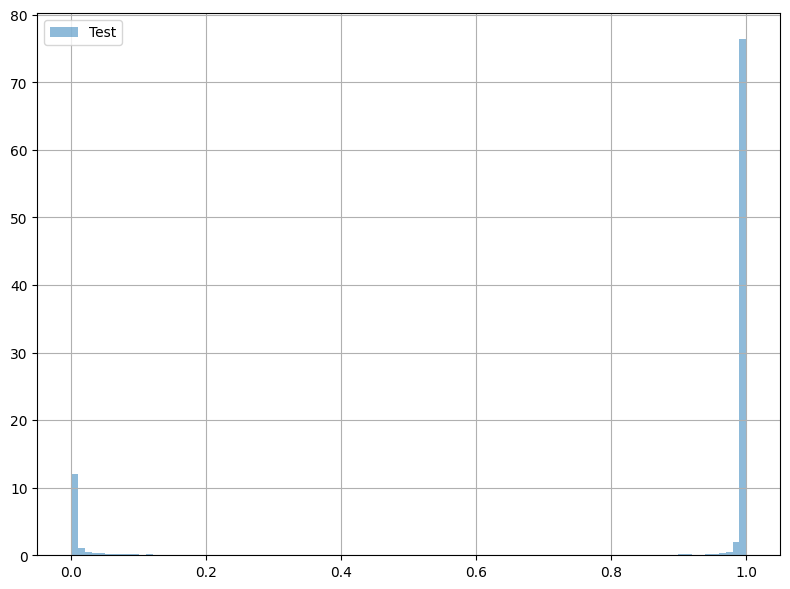

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 1, 100)
ax.hist(sample_submission['target'], bins=bins, density=True, alpha=.5, label="Test")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [34]:
sample_submission

,target
0,0.999922
1,0.354433
2,0.999626
3,0.715821
4,0.999491
...,...
11150,0.999916
11151,0.999926
11152,0.999934
11153,0.999659


In [35]:
assert sample_submission["target"].equals(results.reset_index(drop=True)["target"])

In [36]:
sample_submission.to_csv('qwen2_ver1_infer.csv', index=False)